In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer

In [2]:
# Use your own data here
data = pd.read_csv('vars.csv')
data.head()

,Recnum,Date,Fraud,mean_Amount_Cardnum_0,actual_by_mean_Amount_Cardnum_0,mean_Amount_Cardnum_1,actual_by_mean_Amount_Cardnum_1,mean_Amount_Cardnum_2,actual_by_mean_Amount_Cardnum_2,mean_Amount_Cardnum_3,...,Cardnum_Merch_zip_count_1_by_14,Cardnum_Merch_zip_count_1_by_30,Cardnum_Merch_state_count_0_by_3,Cardnum_Merch_state_count_0_by_7,Cardnum_Merch_state_count_0_by_14,Cardnum_Merch_state_count_0_by_30,Cardnum_Merch_state_count_1_by_3,Cardnum_Merch_state_count_1_by_7,Cardnum_Merch_state_count_1_by_14,Cardnum_Merch_state_count_1_by_30
0,1,2010-01-01,0,3.624545,0.998746,3.624545,0.998746,3.624545,0.998746,3.624545,...,14.0,30.0,3.0,7.0,14.0,30.0,3.0,7.0,14.0,30.0
1,5,2010-01-01,0,3.624545,0.998746,3.624545,0.998746,3.624545,0.998746,3.624545,...,14.0,30.0,3.0,7.0,14.0,30.0,3.0,7.0,14.0,30.0
2,10,2010-01-01,0,3.624545,0.998746,3.624545,0.998746,3.624545,0.998746,3.624545,...,14.0,30.0,3.0,7.0,14.0,30.0,3.0,7.0,14.0,30.0
3,12,2010-01-01,0,3.624545,0.998746,3.624545,0.998746,3.624545,0.998746,3.624545,...,14.0,30.0,3.0,7.0,14.0,30.0,3.0,7.0,14.0,30.0
4,21,2010-01-01,0,3.624545,0.998746,3.624545,0.998746,3.624545,0.998746,3.624545,...,14.0,30.0,3.0,7.0,14.0,30.0,3.0,7.0,14.0,30.0


In [3]:
data['Date'] = pd.to_datetime(data['Date'])
mydata = data[(data.Date < '2010-11-01') & (data.Date > '2010-01-14')]
mydata = mydata.iloc[:, 2:]
mydata['RANDOM'] = np.random.randn(mydata.shape[0])

### KS and FDR

In [4]:
columns = mydata.columns
KSFDR = pd.DataFrame(index=columns, columns= ['KS', 'FDR'])
KSFDR.head()

,KS,FDR
Fraud,NaN,NaN
mean_Amount_Cardnum_0,NaN,NaN
actual_by_mean_Amount_Cardnum_0,NaN,NaN
mean_Amount_Cardnum_1,NaN,NaN
actual_by_mean_Amount_Cardnum_1,NaN,NaN


In [5]:
goods = mydata[mydata.Fraud == 1]
bads = mydata[mydata.Fraud == 0]
i = 0
for column in columns:
    KSFDR.loc[column, 'KS'] = sps.ks_2samp(goods[column], bads[column])[0]
    i += 1
    if i % 100 == 0:
        print(f'{i} columns are done!')

100 columns are done!
200 columns are done!
300 columns are done!


In [6]:
topRows = int(round(mydata.shape[0]*0.03))
numbads = sum(mydata['Fraud'])
i = 0
for column in columns:
    if column == 'Fraud':
        temp = mydata[[column]].copy()
    else:
        temp = mydata[[column,'Fraud']].copy()
    temp0 = temp.sort_values(column, ascending=False)
    temp1 = temp0.head(topRows)
    temp2 = temp0.tail(topRows)
    needed1 = temp1.loc[:,'Fraud']
    needed2 = temp2.loc[:,'Fraud']
    FDR1 = sum(needed1) / numbads
    FDR2 = sum(needed2) / numbads
    FDRate = np.maximum(FDR1, FDR2)
    KSFDR.loc[column, 'FDR'] = FDRate
    i += 1
    if i % 100 == 0:
        print(f'{i} columns are done!')

100 columns are done!
200 columns are done!
300 columns are done!


In [7]:
KSFDR.reset_index(inplace=True)
KSFDR.columns = ['Variable', 'KS', 'FDR']

In [8]:
KSFDR['rank_KS'] = KSFDR['KS'].rank(ascending=True)
KSFDR['rank_FDR'] = KSFDR['FDR'].rank(ascending=True)
KSFDR['average_rank'] = (KSFDR['rank_KS'] + KSFDR['rank_FDR']) / 2
KSFDR.sort_values(by=['average_rank'], ascending=False, inplace=True)

In [14]:
KSFDR.head(10)

,Variable,KS,FDR,rank_KS,rank_FDR,average_rank
0,Fraud,1,1,362.0,362.0,362.00
273,sum_Amount_Cardnum_Merch_state_3,0.684202,0.495392,356.0,353.0,354.50
271,sum_Amount_Cardnum_Merch_state_2,0.680088,0.483871,354.0,343.5,348.75
193,max_Amount_Cardnum_Merch_zip_14,0.663028,0.488479,346.0,349.0,347.50
277,sum_Amount_Cardnum_Merch_state_14,0.690695,0.465438,361.0,333.0,347.00
137,max_Amount_Cardnum_Merchnum_14,0.662209,0.487327,344.0,348.0,346.00
269,sum_Amount_Cardnum_Merch_state_1,0.66706,0.483871,348.0,343.5,345.75
195,max_Amount_Cardnum_Merch_zip_30,0.655691,0.491935,339.0,350.5,344.75
275,sum_Amount_Cardnum_Merch_state_7,0.688828,0.459677,358.0,331.5,344.75
139,max_Amount_Cardnum_Merchnum_30,0.65753,0.486175,341.0,346.5,343.75


In [9]:
KSFDR.tail(10)

,Variable,KS,FDR,rank_KS,rank_FDR,average_rank
24,actual_by_max_Amount_Cardnum_7,0.16235,0.0207373,32.0,26.0,29.0
80,actual_by_max_Amount_Merchnum_7,0.156263,0.0207373,29.0,26.0,27.5
252,actual_by_max_Amount_Cardnum_Merch_state_30,0.154675,0.0195853,28.0,23.0,25.5
334,Merchnum_count_1_by_7,0.142433,0.0230415,21.0,30.0,25.5
333,Merchnum_count_1_by_3,0.12812,0.0264977,15.0,33.0,24.0
361,RANDOM,0.0126774,0.031106,1.0,43.0,22.0
74,actual_by_max_Amount_Merchnum_1,0.144177,0.0138249,22.0,18.0,20.0
76,actual_by_max_Amount_Merchnum_2,0.131376,0.0138249,18.0,18.0,18.0
78,actual_by_max_Amount_Merchnum_3,0.130939,0.0126728,16.0,16.0,16.0
325,Cardnum_count_1_by_3,0.0838749,0.0115207,2.0,14.0,8.0


In [10]:
columns = KSFDR.iloc[:81, :].Variable
mydata = mydata[columns]

In [11]:
mydata.head()

,Fraud,sum_Amount_Cardnum_Merch_state_3,sum_Amount_Cardnum_Merch_state_2,max_Amount_Cardnum_Merch_zip_14,sum_Amount_Cardnum_Merch_state_14,max_Amount_Cardnum_Merchnum_14,sum_Amount_Cardnum_Merch_state_1,max_Amount_Cardnum_Merch_zip_30,sum_Amount_Cardnum_Merch_state_7,max_Amount_Cardnum_Merchnum_30,...,mean_Amount_Cardnum_Merch_state_0,mean_Amount_Cardnum_Merch_zip_3,mean_Amount_Cardnum_Merch_state_30,mean_Amount_Cardnum_Merch_state_2,mean_Amount_Cardnum_7,mean_Amount_Cardnum_Merch_state_1,median_Amount_Cardnum_2,mean_Amount_Cardnum_Merchnum_3,median_Amount_Cardnum_1,mean_Amount_Cardnum_Merch_zip_2
3338,0,333.47,333.47,983.66,1960.27,983.66,333.47,983.66,1960.27,983.66,...,333.4700,333.470000,653.423333,333.470000,399.058889,333.4700,310.305,333.470000,333.47,333.470000
3339,0,43.59,43.59,466.36,726.32,466.36,43.59,466.36,509.95,466.36,...,43.5900,43.590000,181.580000,43.590000,246.316667,43.5900,43.590,43.590000,43.59,43.590000
3340,0,106.42,106.42,106.42,106.42,106.42,106.42,106.42,106.42,106.42,...,106.4200,106.420000,106.420000,106.420000,106.420000,106.4200,106.420,106.420000,106.42,106.420000
3341,0,7044.25,3289.75,15.40,15834.50,15.40,2693.25,15.40,11114.75,15.40,...,4.3092,4.943333,4.460423,4.537586,11.469687,4.3092,4.370,4.799464,4.37,4.537586
3342,0,7044.25,3289.75,15.40,15834.50,15.40,2693.25,15.40,11114.75,15.40,...,4.3092,4.943333,4.460423,4.537586,11.469687,4.3092,4.370,4.799464,4.37,4.537586


### Forward Selection

In [12]:
def get_fdr(model, X, y):
    y_pred = model.predict_proba(X)[:, 1]
    temp = pd.DataFrame({'y': y, 'y_pred': y_pred})
    actual_pos = y.sum()
    temp = temp.sort_values('y_pred', ascending=False)
    target_num = int(temp.shape[0] * 0.03)
    temp = temp.iloc[:target_num, :]
    detect_pos = temp['y'].sum()
    fdr = detect_pos / actual_pos
    return fdr

In [14]:
X = mydata.drop(columns=['Fraud'])
y = mydata['Fraud']

In [16]:
model = LogisticRegression()
sfs = SFS(model, k_features=80, forward=True, verbose=2, scoring=get_fdr, cv=0, n_jobs=2)
sfs.fit(X, y)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed:    3.8s
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:    6.2s finished

[2021-04-22 19:43:08] Features: 1/80 -- score: 0.511520737327189[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    4.2s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    8.1s finished

[2021-04-22 19:43:17] Features: 2/80 -- score: 0.6129032258064516[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    5.2s
[Parallel(n_jobs=2)]: Done  78 out of  78 | elapsed:   10.5s finished

[2021-04-22 19:43:28] Features: 3/80 -- score: 0.6543778801843319[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    7.3s
[Parallel(n_jobs=2)]: Done  77 out of  77 | elaps

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   17.3s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   23.0s finished

[2021-04-22 19:52:37] Features: 31/80 -- score: 0.4804147465437788[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   15.7s
[Parallel(n_jobs=2)]: Done  49 out of  49 | elapsed:   20.5s finished

[2021-04-22 19:52:58] Features: 32/80 -- score: 0.47580645161290325[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   17.7s
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:   22.7s finished

[2021-04-22 19:53:21] Features: 33/80 -- score: 0.4815668202764977[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   17.6s
[Parallel(n_jobs=2)]: Done  47 out of  47 | elapsed:   22.3s finished

[2021-04-22 19:53:44] Features: 34/80 -- score: 

[Parallel(n_jobs=2)]: Done  14 out of  14 | elapsed:    9.6s finished

[2021-04-22 20:04:19] Features: 67/80 -- score: 0.478110599078341[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  13 out of  13 | elapsed:    9.1s finished

[2021-04-22 20:04:29] Features: 68/80 -- score: 0.4769585253456221[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    8.7s finished

[2021-04-22 20:04:37] Features: 69/80 -- score: 0.4815668202764977[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  11 out of  11 | elapsed:    8.7s finished

[2021-04-22 20:04:46] Features: 70/80 -- score: 0.4665898617511521[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    8.0s finished

[2021-04-22 20:04:55] Features: 71/80 -- score: 0.4792626728110599[Parallel(n_jobs

SequentialFeatureSelector(cv=0, estimator=LogisticRegression(), k_features=80,
                          n_jobs=2,
                          scoring=<function get_fdr at 0x000001B0BDAB7EE0>,
                          verbose=2)

In [17]:
vars_class = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

C:\Users\ouxin\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\ouxin\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\ouxin\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\ouxin\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(1.0, 10.0)

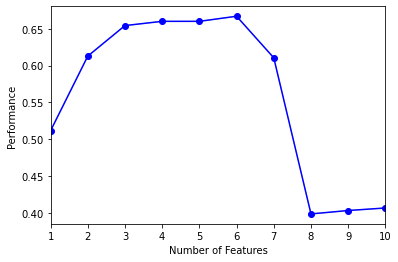

In [20]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig1 = plot_sfs(sfs.get_metric_dict(),
                kind='std_dev',
                figsize=(6, 4))
plt.xlim(1, 10)

C:\Users\ouxin\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\ouxin\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]),
 <a list of 80 Text major ticklabel objects>)

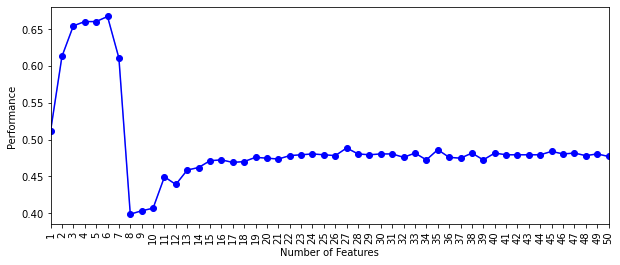

In [37]:
fig1 = plot_sfs(sfs.get_metric_dict(),
                kind='std_dev',
                figsize=(10, 4))
plt.xlim(1, 50)
plt.xticks(rotation=90)

In [27]:
vars_class['num_features'] = vars_class['feature_idx'].apply(len)

In [72]:
temp = vars_class[vars_class['num_features'] == 30]
print(temp.avg_score)
print(temp.feature_names.to_list())

30    0.480415
Name: avg_score, dtype: object
[('sum_Amount_Cardnum_Merch_state_2', 'sum_Amount_Cardnum_Merch_state_14', 'sum_Amount_Cardnum_Merch_state_1', 'max_Amount_Cardnum_Merch_zip_30', 'max_Amount_Cardnum_Merchnum_30', 'max_Amount_Cardnum_Merch_state_7', 'max_Amount_Cardnum_Merch_state_14', 'max_Amount_Cardnum_Merch_zip_3', 'max_Amount_Cardnum_Merch_state_2', 'sum_Amount_Cardnum_Merch_zip_2', 'sum_Amount_Cardnum_Merch_zip_14', 'max_Amount_Cardnum_Merch_state_30', 'sum_Amount_Cardnum_Merch_zip_30', 'sum_Amount_Cardnum_Merchnum_7', 'sum_Amount_Cardnum_Merchnum_30', 'sum_Amount_Cardnum_Merch_zip_1', 'max_Amount_Cardnum_Merch_zip_1', 'max_Amount_Cardnum_Merchnum_1', 'sum_Amount_Cardnum_Merch_state_30', 'sum_Amount_Cardnum_1', 'sum_Amount_Cardnum_0', 'sum_Amount_Cardnum_Merchnum_1', 'max_Amount_Cardnum_7', 'max_Amount_Cardnum_0', 'max_Amount_Cardnum_14', 'mean_Amount_Cardnum_3', 'sum_Amount_Cardnum_30', 'mean_Amount_Cardnum_Merch_state_0', 'mean_Amount_Cardnum_Merch_state_1', 'median

In [73]:
temp = vars_class[vars_class['num_features'] == 6]
print(temp.avg_score)
print(temp.feature_names.to_list())

6    0.667051
Name: avg_score, dtype: object
[('max_Amount_Cardnum_Merch_zip_30', 'max_Amount_Cardnum_Merch_state_14', 'sum_Amount_Cardnum_Merch_zip_14', 'sum_Amount_Cardnum_Merch_zip_30', 'sum_Amount_Cardnum_Merchnum_7', 'max_Amount_Cardnum_7')]


In [74]:
vars_30 = ['sum_Amount_Cardnum_Merch_state_2', 'sum_Amount_Cardnum_Merch_state_14', 
           'sum_Amount_Cardnum_Merch_state_1', 'max_Amount_Cardnum_Merch_zip_30', 
           'max_Amount_Cardnum_Merchnum_30', 'max_Amount_Cardnum_Merch_state_7', 
           'max_Amount_Cardnum_Merch_state_14', 'max_Amount_Cardnum_Merch_zip_3', 
           'max_Amount_Cardnum_Merch_state_2', 'sum_Amount_Cardnum_Merch_zip_2', 
           'sum_Amount_Cardnum_Merch_zip_14', 'max_Amount_Cardnum_Merch_state_30', 
           'sum_Amount_Cardnum_Merch_zip_30', 'sum_Amount_Cardnum_Merchnum_7', 'sum_Amount_Cardnum_Merchnum_30', 
           'sum_Amount_Cardnum_Merch_zip_1', 'max_Amount_Cardnum_Merch_zip_1', 'max_Amount_Cardnum_Merchnum_1', 
           'sum_Amount_Cardnum_Merch_state_30', 'sum_Amount_Cardnum_1', 'sum_Amount_Cardnum_0', 
           'sum_Amount_Cardnum_Merchnum_1', 'max_Amount_Cardnum_7', 'max_Amount_Cardnum_0', 
           'max_Amount_Cardnum_14', 'mean_Amount_Cardnum_3', 'sum_Amount_Cardnum_30', 
           'mean_Amount_Cardnum_Merch_state_0', 'mean_Amount_Cardnum_Merch_state_1', 'median_Amount_Cardnum_2']

vars_6 = ['max_Amount_Cardnum_Merch_zip_30', 'max_Amount_Cardnum_Merch_state_14', 'sum_Amount_Cardnum_Merch_zip_14',
          'sum_Amount_Cardnum_Merch_zip_30', 'sum_Amount_Cardnum_Merchnum_7', 'max_Amount_Cardnum_7']

In [80]:
data[['Recnum', 'Date', 'Fraud'] + vars_30].to_csv('vars_30.csv', index=False)